#### This file contains code to replicate the main results of the temporal instability paper

In [49]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from repeated_scenarios import *
import seaborn as sns
import scipy
from tqdm.notebook import tqdm
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from stability_utils import *
import pingouin as pg
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from scipy.stats import kruskal
import shap
from stargazer.stargazer import Stargazer
from sklearn.isotonic import spearmanr
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
###
df = pd.read_csv('./data/main_response_data/main_response_data_qualtrics_participants.csv')
df = df.reset_index(drop=True)

df = df[df.attfailed == 0]

In [4]:
nsess = 3
nusers = 0
for user in df.tid.unique():
    ns = len(df[df.tid == user].session_number.unique())
    if ns >= nsess:
        nusers += 1

nusers

404

### response stability

In [5]:
group1_to_use = ["G1E4", "G1E5"]
group2_to_use = ["G2D4", "G2D5"]
group3_to_use = ["G3D5", "G3D6"]
scenarios = group1_to_use + group2_to_use + group3_to_use

groups_to_print_labels = {
    "G1E4": "$U_1$",
    "G1E5": "$U_2$",
    "G2D4": "$V_1$",
    "G2D5": "$V_2$",
    "G3D5": "$W_1$",
    "G3D6": "$W_2$"
}

In [6]:
from stability_utils import *

methods = ["stability", "consistency_continuous", "consistency_sessions", "std"]
stability_by_methods = {method: {pairid: [] for pairid in scenarios} for method in methods}
stability, agreement = {pairid: [] for pairid in scenarios}, {pairid: [] for pairid in scenarios}        
stability_by_user = []

print (df['tid'].nunique())

## variable limit specififies the minimum number of responses required for a scenario pair
all_responses = get_all_repeated_responses(df, scenarios, limit=6)

for id, responses in tqdm(all_responses.items()):
    for pairid in scenarios:
        for method in methods:
            stab = get_stability(responses[pairid], method)
            stability_by_methods[method][pairid].append(stab)

        agreement[pairid] += responses[pairid]

        stability_by_user.append([id, pairid, len(responses[pairid]), get_stability(responses[pairid], "stability")])

len(all_responses)




1227


  0%|          | 0/1227 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

404

In [7]:
stability_by_user_df = pd.DataFrame(stability_by_user, columns=["user", "pairid", "num_responses", "stability"])
stability_by_user_df.num_responses.value_counts()

num_responses
8     1112
10     752
6      496
12      24
9       14
7        8
11       6
14       6
5        3
4        3
Name: count, dtype: int64

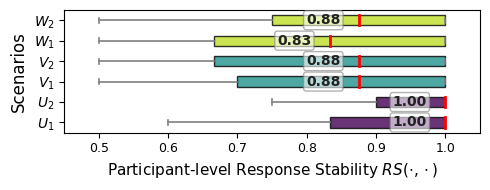

In [51]:
### plot average response stability levels across participants

import matplotlib as mpl
ys, es = [], []

plt.figure(figsize = (5, 2), dpi=100)
stability = stability_by_methods["stability"]
for pairid in scenarios:
    ys.append(np.nanmean(stability[pairid]))
    es.append(np.nanstd(stability[pairid]))

colors = plt.cm.viridis([0, 0, 0.5, 0.5, 0.9, 0.9])

ax = plt.boxplot([stability[pairid] for pairid in scenarios], 
                 vert=False, 
                 patch_artist=True, 
                 labels=[groups_to_print_labels[pairid] for pairid in scenarios],
                 boxprops=dict(alpha=0.8),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(color='gray', linewidth=1.2),
                 capprops=dict(color='gray', linewidth=1.2),
                 showfliers=False)

# Color boxes according to the viridis colormap
for patch, color in zip(ax['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

plt.xlabel("Participant-level Response Stability $RS(\cdot,\cdot)$", fontsize=11)
plt.ylabel("Scenarios", fontsize=12)
plt.xlim(0.45, 1.05)
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)

# Add median annotations with clean, non-overlapping positioning and subtle styling
for i, pairid in enumerate(scenarios):
    data = stability[pairid]
    median = np.median(data)
    # Place annotation just right of the median line, vertically centered on the box
    plt.annotate(
        f"{median:.2f}",
        xy=(median-0.1, i + 1),
        xytext=(12, 0),
        textcoords='offset points',
        fontsize=10,
        va='center',
        ha='left',
        fontweight='bold',
        color='#222222',
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="gray", alpha=0.6)
    )

plt.tight_layout()
# plt.savefig("./aaai_images/response_stability.png", bbox_inches='tight', dpi=100)



# for i, p in enumerate(ax.patches):
#     annstr = str(np.round(p.get_width(),2))
#     if annstr == "0.9":
#         annstr = "0.90"
#     plt.annotate(annstr, (p.get_width() * 1.02, p.get_y()+0.5), fontsize=10)
#     err = "$\pm$"+str(np.round(es[i],2))
#     plt.annotate(err, (p.get_width() * 1.08,  p.get_y()+0.5), fontsize=8)
# # plt.savefig("./aaai_images/response_stability.png", bbox_inches='tight')


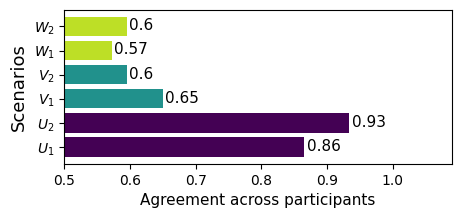

In [916]:
### plot agreement levels across participants
# 
plt.figure(figsize = (5, 2), dpi=100)
ys, es = [], []
for pairid in scenarios:
    a = np.mean(agreement[pairid])
    a = 1-a if a < 0.5 else a
    ys.append(a)
colors = plt.cm.viridis([0, 0, 0.5, 0.5, 0.9, 0.9])

ax = plt.barh(list(groups_to_print_labels.values()), ys, color=colors)
plt.xlabel("Agreement across participants", fontsize=11)
plt.ylabel("Scenarios", fontsize=13)
plt.xlim(0.5, 1.09)

for p in ax.patches:
    plt.annotate(str(np.round(p.get_width(),2)), (p.get_width() * 1.005, p.get_y()+0.25), fontsize=11)

plt.subplots_adjust(wspace=0.2)
plt.savefig("./aaai_images/agreement.png", bbox_inches='tight')
# plt.show()


In [ ]:
### tests for statistical significance of differences in stability across groups

print (kruskal( stability[group1_to_use[0]],
                stability[group1_to_use[1]],
                stability[group2_to_use[0]],
                stability[group2_to_use[1]],
                stability[group3_to_use[0]],
                stability[group3_to_use[1]]))

stab_df = []
for pairid in scenarios:
    for stab in stability[pairid]:
        stab_df.append([pairid, stab])

stab_df = pd.DataFrame(stab_df, columns=['pairid', 'stability'])
tukey = pairwise_tukeyhsd(endog=stab_df['stability'],
                          groups=stab_df['pairid'],
                          alpha=0.05)

print (tukey.summary())


KruskalResult(statistic=222.22746414340256, pvalue=4.952040992620193e-46)
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  G1E4   G1E5   0.0338 0.0239  0.0027   0.065   True
  G1E4   G2D4  -0.0734    0.0 -0.1046 -0.0423   True
  G1E4   G2D5  -0.0831    0.0 -0.1142 -0.0519   True
  G1E4   G3D5  -0.0882    0.0 -0.1194 -0.0571   True
  G1E4   G3D6  -0.0514    0.0 -0.0825 -0.0203   True
  G1E5   G2D4  -0.1073    0.0 -0.1384 -0.0762   True
  G1E5   G2D5  -0.1169    0.0 -0.1481 -0.0858   True
  G1E5   G3D5  -0.1221    0.0 -0.1532 -0.0909   True
  G1E5   G3D6  -0.0852    0.0 -0.1164 -0.0541   True
  G2D4   G2D5  -0.0096 0.9507 -0.0408  0.0215  False
  G2D4   G3D5  -0.0148 0.7544 -0.0459  0.0163  False
  G2D4   G3D6    0.022 0.3313 -0.0091  0.0532  False
  G2D5   G3D5  -0.0051 0.9971 -0.0363   0.026  False
  G2D5   G3D6   0.0317 0.0433  0.0006  0.0628   True
  G3D5   G3D6   0.0368 0.

### Coefficient analysis

In [52]:
feats = ['dep', 'alco', 'crim', 'life',
           'years_waiting', 'work_hours', 'obesity', 'reject_chance']

for f in feats:
    df[f+"_diff"] = df["l_"+f] - df["r_"+f]

diff_cols = [f+"_diff" for f in feats]
l_cols = ["l_"+f for f in feats]
r_cols = ["r_"+f for f in feats]

df_diff = df[~df.pairid.isin(scenarios)][["tid"] + diff_cols + ["pairid", "chosen", 'created_at', 'session_number', 'reaction_time']]

# exlcude attention check questions
df_diff = df_diff[df_diff['reject_chance_diff'] != 100]
df_diff = df_diff[df_diff['reject_chance_diff'] != -100]

q_low = df_diff["reaction_time"].quantile(0.025)
q_hi  = df_diff["reaction_time"].quantile(0.975)

print (q_low, q_hi)

df_diff = df_diff[(df["reaction_time"] < q_hi) & (df_diff["reaction_time"] > q_low)]


for user in df_diff.tid.unique():
    df_temp_user = df_diff[df_diff.tid == user]
    reaction_times = df_temp_user['reaction_time'].values
    max_rt, min_rt = np.max(reaction_times), np.min(reaction_times)
    df_diff.loc[df_diff.tid == user, 'reaction_time'] = (df_temp_user['reaction_time'] - min_rt) / (max_rt - min_rt)


df_diff.head()


0.7164524000000001 130.29330119999972


,tid,dep_diff,alco_diff,crim_diff,life_diff,years_waiting_diff,work_hours_diff,obesity_diff,reject_chance_diff,pairid,chosen,created_at,session_number,reaction_time
0,10035193,0,3,1,-10,8,20,2,-1,3_3_1_5_11_20_3_2|3_0_0_15_3_0_1_3,0,2024-08-10 20:46:21,1.0,1.000000
1,10035193,-3,-1,0,-15,2,-10,-1,10,0_1_1_10_11_30_2_20|3_2_1_25_9_40_3_10,0,2024-08-10 20:46:47,1.0,0.239455
2,10035193,3,1,2,0,0,0,-2,0,G2D4_r,0,2024-08-10 20:47:16,1.0,0.274532
4,10035193,0,-1,-1,5,0,20,0,14,2_2_1_25_3_40_0_15|2_3_2_20_3_20_0_1,1,2024-08-10 20:47:55,1.0,0.157752
5,10035193,2,0,0,0,-4,0,-1,-3,G2D5_r,1,2024-08-10 20:48:11,1.0,0.148279


In [53]:

scenarios = group1_to_use + group2_to_use + group3_to_use

coef_dict = {}
shap_dict = {}
att_failed = 0
id_to_scalar = {}
for id in tqdm(all_responses.keys()):
    df_user = df_diff[df_diff['tid'] == (id)]
    if len(df_user) == 0:
        print (id)
        continue
    
    coefs, shap_mean, scalar, acc, auc = get_clf_model(df_user, reps=1, model_name="lr")
    id_to_scalar[id] = scalar
    
    coefs = np.mean(coefs, axis=0)
    coef_dict[id] = dict(zip(diff_cols, coefs))
    coef_dict[id]["acc"] = acc
    coef_dict[id]["auc"] = auc

    shap_coefs = np.mean(shap_mean, axis=0)
    shap_dict[id] = dict(zip(diff_cols, shap_coefs))



  0%|          | 0/404 [00:00<?, ?it/s]

In [54]:
acc_cols = ["acc", "auc"]
coef_diff_df = pd.DataFrame.from_dict(coef_dict, orient='index', columns=diff_cols+acc_cols)
shap_df = pd.DataFrame.from_dict(shap_dict, orient='index', columns=diff_cols)
shap_df

,dep_diff,alco_diff,crim_diff,life_diff,years_waiting_diff,work_hours_diff,obesity_diff,reject_chance_diff
5476939,0.136427,0.000951,0.013161,0.121676,0.013297,0.124330,0.038060,0.052065
5625634,0.074766,0.004631,0.026688,0.261361,0.052883,0.011911,0.038939,0.112305
2750733,0.022985,0.012439,0.001408,0.190509,0.077745,0.062273,0.010970,0.064318
3392798,0.092556,0.031039,0.042625,0.309940,0.036740,0.008203,0.024900,0.010897
5527300,0.034486,0.021014,0.036472,0.288624,0.067608,0.057275,0.014348,0.027955
...,...,...,...,...,...,...,...,...
11034831,0.013353,0.009643,0.004954,0.064100,0.004574,0.022163,0.008850,0.283697
3304950,0.099473,0.084181,0.027192,0.060476,0.012749,0.014838,0.005009,0.029138
10963783,0.136445,0.016028,0.030809,0.147547,0.027634,0.062441,0.027302,0.140038
5948426,0.040679,0.028864,0.000065,0.112670,0.265625,0.003602,0.026192,0.030133


In [55]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sp = []
for id in tqdm(all_responses.keys()):
    coefs = coef_dict[id]
    coef_vals = [coefs[f] for f in diff_cols]
    for pairid in scenarios:
        p1 = repeated_scenarios[pairid]['p1']
        p2 = repeated_scenarios[pairid]['p2']

        stab = np.mean(all_responses[id][pairid])
        stab = np.max([stab, 1-stab])
        if np.isnan(stab):
            continue
        
        pdiff = [p1[f[:-5]]-p2[f[:-5]] for f in diff_cols]
        pdiff = id_to_scalar[id].transform([pdiff])[0]

        score = (np.abs(np.dot(pdiff, coef_vals)))
        shap_coefs = shap_df.loc[id].values
        shap_entropy = scipy.stats.entropy(np.abs(shap_coefs))
    
        rt1 = list(df_diff[(df_diff['tid'] == id) & (df_diff['pairid'] == pairid)].reaction_time.values)
        rt2 = list(df_diff[(df_diff['tid'] == id) & (df_diff['pairid'] == pairid+"_r")].reaction_time.values)
        reaction_times = rt1 + rt2

        sp.append([id, pairid, stab, -score, shap_entropy, np.mean(reaction_times)])
        
sp_df = pd.DataFrame(sp, columns=["user", "scenario", "stability", "difficulty", "model_entropy", "mean_reaction_time"])
len(sp_df)/6

  0%|          | 0/404 [00:00<?, ?it/s]

404.0

In [16]:
sp_df["group"] = 1

vcf = {"scenario": "0 + C(scenario)", "user": "0 + C(user)"}                                                         
model = sm.MixedLM.from_formula("stability ~ difficulty + model_entropy + mean_reaction_time", groups="group",                                                    
                                vc_formula=vcf, re_formula="0", data=sp_df[~pd.isna(sp_df['mean_reaction_time'])]).fit()
print (model.summary())


            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   stability
No. Observations:    2414      Method:               REML     
No. Groups:          1         Scale:                0.0152   
Min. group size:     2414      Log-Likelihood:       1504.0474
Max. group size:     2414      Converged:            Yes      
Mean group size:     2414.0                                   
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           0.938    0.023  40.345 0.000  0.892  0.983
difficulty         -0.049    0.002 -24.416 0.000 -0.053 -0.045
model_entropy      -0.108    0.013  -8.253 0.000 -0.134 -0.082
mean_reaction_time -0.056    0.031  -1.816 0.069 -0.116  0.004
scenario Var        0.000    0.002                            
user Var            0.002    0.003                            



In [ ]:
stargazer = Stargazer([model])
print (stargazer.render_latex())


G1E4 SignificanceResult(statistic=-0.6620819993193809, pvalue=2.6272227250126365e-52)
G1E5 SignificanceResult(statistic=-0.5634164370011736, pvalue=3.2284847352517185e-35)
G2D4 SignificanceResult(statistic=-0.5100831917885197, pvalue=3.825400168238709e-28)
G2D5 SignificanceResult(statistic=-0.5575333474427033, pvalue=2.2533677993533986e-34)
G3D5 SignificanceResult(statistic=-0.45460321799859055, pvalue=5.355144297062855e-22)
G3D6 SignificanceResult(statistic=-0.724688897671885, pvalue=5.2707432064031555e-67)


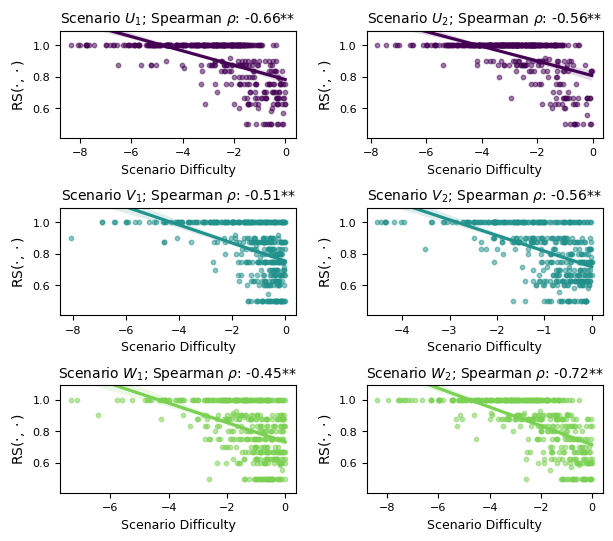

In [1073]:
sp_df["pairid"]  = sp_df["scenario"]
plot_stability_correlation(sp_df, 
                        #    ["$U_1$", "$V_1$", "$W_1$", "$U_2$", "$V_2$", "$W_2$"], 
                            ["$U_1$", "$U_2$", "$V_1$", "$V_2$", "$W_1$", "$W_2$"],
                           xl="difficulty", xlabel="Scenario Difficulty", 
                           fname="./aaai_images/scenario_difficulty_stability.png",)

G1E4 SignificanceResult(statistic=-0.08776312524308559, pvalue=0.0780773428592556)
G1E5 SignificanceResult(statistic=-0.2570839312207146, pvalue=1.6089373153982205e-07)
G2D4 SignificanceResult(statistic=-0.20460723931716215, pvalue=3.417001795201501e-05)
G2D5 SignificanceResult(statistic=-0.3539340785816169, pvalue=2.2917711722416286e-13)
G3D5 SignificanceResult(statistic=-0.465528409005576, pvalue=4.031815200864765e-23)
G3D6 SignificanceResult(statistic=-0.44593376348289504, pvalue=3.906477086890106e-21)


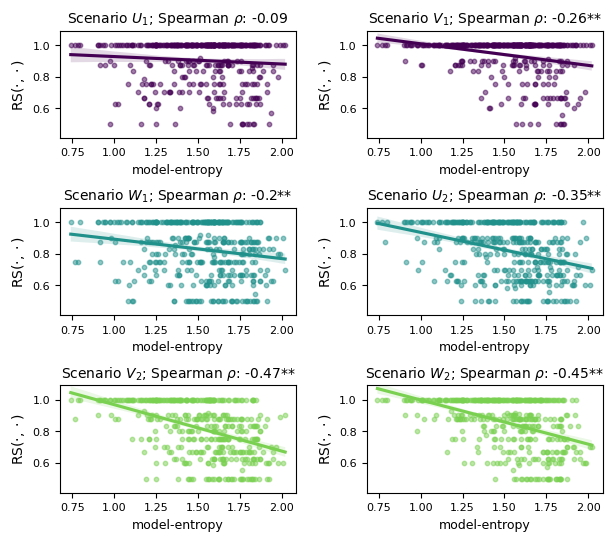

In [1074]:
sp_df["pairid"]  = sp_df["scenario"]
plot_stability_correlation(sp_df, 
                           ["$U_1$", "$V_1$", "$W_1$", "$U_2$", "$V_2$", "$W_2$"], 
                           xl="model_entropy", xlabel="model-entropy", 
                           fname="./aaai_images/scenario_entropy.png",)

### model stability

In [56]:
sesssion_summary_df = []

for id in tqdm(all_responses.keys()):
    df_user = df_diff[df_diff['tid'] == (id)]
    sessions = sorted(df_user['session_number'].unique())

    for sess in sessions:
        df_sess = df_user[df_user['session_number'] == sess]
        coefs, shap_mean, scalar, acc, auc = get_clf_model(df_sess, reps=2, model_name="lr")

        start_time = df_sess['created_at'].min()
        end_time = df_sess['created_at'].max()
        shap_coefs = np.mean(shap_mean, axis=0)
        mean_reaction_time = df_sess['reaction_time'].mean()

        sesssion_summary_df.append([id, sess, start_time, end_time, mean_reaction_time] + list(shap_coefs) + [acc, auc])

sesssion_summary_df = pd.DataFrame(sesssion_summary_df, columns=['user', 'session_number', 'start_time', 'end_time', 'mean_reaction_time'] + diff_cols + acc_cols)

  0%|          | 0/404 [00:00<?, ?it/s]

In [58]:
# sesssion_summary_df

In [ ]:
shift_df = []

for user in tqdm(sesssion_summary_df.user.unique()):
    user_df = sesssion_summary_df[sesssion_summary_df.user == user]
    sessions = sorted(user_df['session_number'].unique())

    for sess1, sess2 in itertools.combinations(sessions, 2):
        if sess2 > 5 or sess2 < 2 or sess1 == sess2:
            continue
    
        user_df_coefs1 = user_df[user_df['session_number'] == sess1][diff_cols]
        user_df_coefs2 = user_df[user_df['session_number'] == sess2][diff_cols]

        corr = scipy.stats.spearmanr(user_df_coefs1.values[0], user_df_coefs2.values[0])[0]
        dist = np.linalg.norm(user_df_coefs1.values[0] - user_df_coefs2.values[0])**2
 
        cumulative_dist, nsess = 0, 0
        for sess in range(int(sess1+1), int(sess2+1)):
            if sess not in sessions:
                continue
            user_df_coefs2 = user_df[user_df['session_number'] == sess][diff_cols]
            cumulative_dist += np.linalg.norm(user_df_coefs1.values[0] - user_df_coefs2.values[0])**2
            nsess += 1
        
        cumulative_dist = cumulative_dist/nsess

        feat_dists, shap_dists = [], []
        for f in diff_cols:
            feat_dists.append(np.abs(user_df_coefs1[f].values[0] - user_df_coefs2[f].values[0]))

        entropy_diff = np.abs(scipy.stats.entropy(np.abs(user_df_coefs1.values[0])) - scipy.stats.entropy(np.abs(user_df_coefs2.values[0])))

        user_df_time1 = user_df[user_df['session_number'] == sess1]['end_time']
        user_df_time2 = user_df[user_df['session_number'] == sess2]['start_time']
        time_diff = pd.to_datetime(user_df_time2.values[0]) - pd.to_datetime(user_df_time1.values[0])
        time_diff = time_diff.total_seconds()/3600
        # if np.log(time_diff) < 8:
            # continue
 
        # print (time_diff)

        shift_df.append([user, sess1, sess2-sess1, corr, dist, cumulative_dist, entropy_diff, time_diff])

shift_df = pd.DataFrame(shift_df, columns=['user', 'session1', 'interval', 'spearman_corr', 'distance', 'cumulative_dist', 'entropy_diff', 'time_diff'])


  0%|          | 0/404 [00:00<?, ?it/s]

In [274]:
shift_df['time_diff'].describe()

count    2619.000000
mean        0.359873
std         0.504374
min         0.005278
25%         0.166389
50%         0.256389
75%         0.391667
max        11.160278
Name: time_diff, dtype: float64

Spearman's $\rho$ = 0.13, p = 4.89e-12
SignificanceResult(statistic=0.052457135831413024, pvalue=0.007351220266050419)


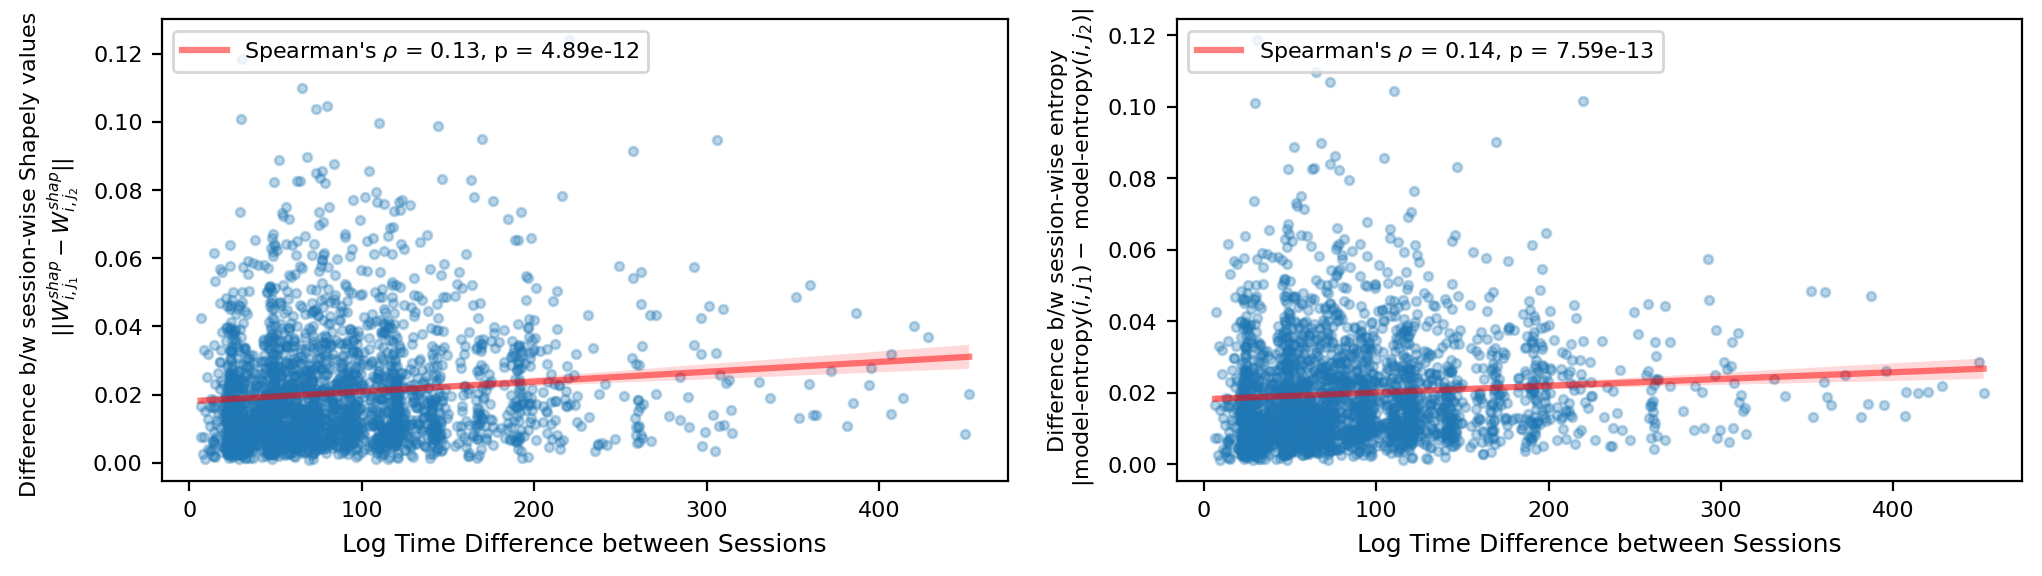

In [75]:
shift_df["log_time_diff"] = (shift_df['time_diff'])
shift_df = shift_df[shift_df.time_diff > 6]
plt.figure(figsize=(12, 3), dpi=200)
plt.subplot(121)
corr=(spearmanr(shift_df['log_time_diff'], shift_df['distance']))
corr_str = f"Spearman's $\\rho$ = {corr[0]:.2f}, p = {corr[1]:.2e}"
print (corr_str)

plt.scatter(shift_df['log_time_diff'], shift_df['distance'], alpha=0.3, s=10)
sns.regplot(x='log_time_diff', y='distance', data=shift_df, scatter=None,
           line_kws={'color':'red', 'alpha':0.5}, label=corr_str)
plt.xlabel("Log Time Difference between Sessions", fontsize=9)
plt.ylabel("Difference b/w session-wise Shapely values \n $||W^{{shap}}_{i, j_1} - W^{{shap}}_{i, j_2}||$", fontsize=8)
plt.legend(fontsize=8, loc='upper left')
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.subplot(122)
plt.scatter(shift_df['log_time_diff'], shift_df['cumulative_dist'], alpha=0.3, s=10)
corr=(spearmanr(shift_df['log_time_diff'], shift_df['cumulative_dist']))
corr_str = f"Spearman's $\\rho$ = {corr[0]:.2f}, p = {corr[1]:.2e}"

sns.regplot(x='log_time_diff', y='cumulative_dist', data=shift_df, scatter=None,
           scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red', 'alpha':0.5}, label=corr_str)
plt.xlabel("Log Time Difference between Sessions", fontsize=9)
plt.ylabel("Difference b/w session-wise entropy\n |model-entropy$(i,j_1) -$ model-entropy$(i,j_2)|$", fontsize=8)
print (spearmanr(shift_df['log_time_diff'], shift_df['entropy_diff']))
plt.legend(fontsize=8, loc='upper left')
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.show()
# plt.savefig("./aaai_images/session_shift_analysis.png", bbox_inches='tight')


Spearman's $\rho$ = 0.14, p = 3.6e-13


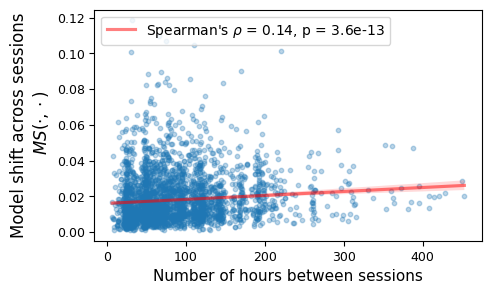

In [1087]:
shift_df["log_time_diff"] = (shift_df['time_diff'])
plt.figure(figsize=(5, 3), dpi=100)
corr=(spearmanr(shift_df['time_diff'], shift_df['cumulative_dist']))
corr_str = f"Spearman's $\\rho$ = {corr[0]:.2f}, p = {corr[1]:.1e}"
print (corr_str)

plt.scatter(shift_df['log_time_diff'], shift_df['cumulative_dist'], alpha=0.3, s=10)
sns.regplot(x='log_time_diff', y='cumulative_dist', data=shift_df, scatter=None, robust=True,
           line_kws={'color':'red', 'alpha':0.5}, label=corr_str)
plt.xlabel("Number of hours between sessions", fontsize=11)
# plt.ylabel("Difference b/w session-wise\n Shapely values: $||W^{{shap}}_{i, j_1} - W^{{shap}}_{i, j_2}||$", fontsize=11)
plt.ylabel("Model shift across sessions\n $MS(\cdot, \cdot)$", fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.yticks(fontsize=9)
plt.xticks(fontsize=9)
plt.savefig("./aaai_images/session_shift_analysis.png", bbox_inches='tight')



In [76]:
user_time_summary = shift_df[['user', 'session1', 'interval', 'time_diff']].copy()
user_time_summary["log_time_diff"] = np.log(user_time_summary['time_diff'])

df_diff_filtered = df_diff[df_diff["tid"].isin(user_time_summary["user"])]
test_df_global = df_diff_filtered.sample(10000, replace=True)

In [77]:
def get_session_times(user_df):
    return user_df.groupby("session_number")["created_at"].min().to_dict()

def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=100)
    model.fit(X_scaled, y)
    return model, scaler


def get_test_set(user_df, exclude_sessions):
    test_df = df_diff_filtered.sample(200, replace=True)

    if len(test_df) < 1:
        return None
    return test_df

feature_cols = diff_cols
target_col = "chosen"

alignment_results = []

for tid, user_df in tqdm(df_diff_filtered.groupby("tid")):
    sessions = sorted(user_df["session_number"].dropna().unique())
    if len(sessions) < 2:
        continue

    for s1, s2 in itertools.combinations(sessions, 2):
        train1 = user_df[user_df["session_number"] == s1]
        train2 = user_df[user_df["session_number"] == s2]

        if train1[target_col].nunique() < 2 or train2[target_col].nunique() < 2:
            continue


        X1, y1 = train1[feature_cols].values, train1[target_col].values
        X2, y2 = train2[feature_cols].values, train2[target_col].values
        model1, scaler1 = train_model(X1, y1)
        model2, scaler2 = train_model(X2, y2)

        agreements = [] 
        # for _ in range(100):
        test = get_test_set(user_df, exclude_sessions=[s1, s2])
        if test is None:
            continue

        ### agreement measure inspired by the work of  Xu et al. - "Measuring error alignment for decision-making systems" (AAAI 2025)
        X_test = test[feature_cols].values
        pred1 = model1.predict(scaler1.transform(X_test))
        pred2 = model2.predict(scaler2.transform(X_test))
        pobs = np.mean(pred1 == pred2)
        pexp = np.mean(pred1) * np.mean(pred2) + (1 - np.mean(pred1)) * (1 - np.mean(pred2))
        agreement = (pobs - pexp) / (1 - pexp) if (1 - pexp) != 0 else 0
        agreements.append(agreement)

        # Ensure session1 < session2 and compute interval for merge
        sess1, sess2 = sorted([s1, s2])
        interval = abs(sess2 - sess1)

        alignment_results.append({
            "user": tid,
            "session1": sess1,
            "session2": sess2,
            "interval": interval,
            "agreement": np.mean(agreements)
        })

results_df = pd.DataFrame(alignment_results)


  0%|          | 0/404 [00:00<?, ?it/s]

In [85]:
merged_df = results_df.merge(
    user_time_summary[["user", "session1", "interval", "time_diff", "log_time_diff"]],
    on=["user", "session1", "interval"],
    how="inner"
)
# merged_df = merged_df[merged_df.time_diff < 300]
merged_df["adjusted_agreement"] = (merged_df["agreement"]) 
merged_df["disagreement"] = 1 - merged_df["agreement"]

merged_df

,user,session1,session2,interval,agreement,time_diff,log_time_diff,adjusted_agreement,disagreement
0,91870,1.0,2.0,1.0,0.575351,93.835833,4.541547,0.575351,0.424649
1,91870,1.0,3.0,2.0,0.403044,167.840278,5.123013,0.403044,0.596956
2,91870,1.0,4.0,3.0,0.480290,213.133056,5.361917,0.480290,0.519710
3,91870,2.0,3.0,1.0,0.617611,73.925278,4.303055,0.617611,0.382389
4,91870,2.0,4.0,2.0,0.379973,119.218056,4.780954,0.379973,0.620027
...,...,...,...,...,...,...,...,...,...
2605,11052140,2.0,4.0,2.0,0.670724,121.767222,4.802111,0.670724,0.329276
2606,11052140,2.0,5.0,3.0,0.678250,192.232222,5.258704,0.678250,0.321750
2607,11052140,3.0,4.0,1.0,0.711558,49.229722,3.896498,0.711558,0.288442
2608,11052140,3.0,5.0,2.0,0.760964,119.694722,4.784945,0.760964,0.239036


Spearman's $\rho$ = -0.11, p = 9.0e-09


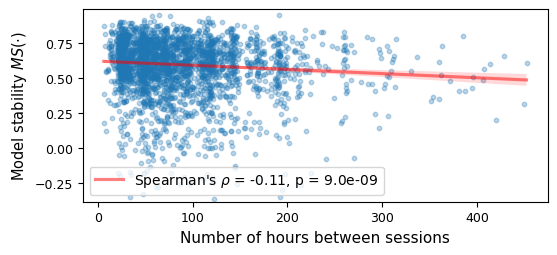

In [79]:
corr = spearmanr(merged_df['time_diff'], merged_df['agreement'])
corr_str = f"Spearman's $\\rho$ = {corr[0]:.2f}, p = {corr[1]:.1e}"
print(corr_str)

plt.figure(figsize=(6, 2.5), dpi=100)

plt.scatter(
    merged_df['time_diff'],
    merged_df['adjusted_agreement'],
    alpha=0.3,
    s=10
)

sns.regplot(
    x='time_diff',
    y='adjusted_agreement',
    data=merged_df,
    scatter=False,
    robust=True,
    line_kws={'color': 'red', 'alpha': 0.5},
    label=corr_str
)

plt.xlabel("Number of hours between sessions", fontsize=11)
plt.ylabel("Model stability $MS(\cdot)$", fontsize=10.5)
plt.legend(fontsize=10, loc='lower left')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.ylim(-0.38, .99)
# plt.savefig("./aaai_images/model_agreement_vs_time.png", bbox_inches='tight')
plt.show()

### participant categorization

In [220]:
cat_df = []

for user in tqdm(sesssion_summary_df.user.unique()):
    user_df = sesssion_summary_df[sesssion_summary_df.user == user]
    sessions = sorted(user_df['session_number'].unique())

    dist, agreement = [], []
    for i in range(1, len(sessions)):
        sess1 = sessions[i-1]
        sess2 = sessions[i]
        if sess2 > 5:
            continue
        user_df_coefs1 = user_df[user_df['session_number'] == sess1][diff_cols]
        user_df_coefs2 = user_df[user_df['session_number'] == sess2][diff_cols]
        # dist += np.linalg.norm(user_df_coefs1.values[0] - user_df_coefs2.values[0])**2

        try:
            dist.append(np.linalg.norm(user_df_coefs1.values[0] - user_df_coefs2.values[0])**2)

            # if user not in merged_df['user'].values:
            #     continue
            
            agreement.append(merged_df[(merged_df['user'] == user) &
                                (merged_df['session1'] == sess1) &
                                (merged_df['session2'] == sess2)]['adjusted_agreement'].values[0])
        except:
            continue

    # dist = dist/(len(sessions)-1)
    # agreement = agreement/(len(sessions)-1)

    stability = stability_by_user_df[stability_by_user_df['user'] == user]['stability'].mean()
    rt = user_df["mean_reaction_time"].mean()
    

    cat_df.append([user, np.mean(dist), stability, rt, np.mean(agreement)])
cat_df = pd.DataFrame(cat_df, columns=['user', 'distance', 'stability', 'mean_reaction_time', 'model_agreement'])




  0%|          | 0/404 [00:00<?, ?it/s]

In [96]:
user, sess1, sess2, merged_df[(merged_df['user'] == user) &
                               (merged_df['session1'] == sess1) &
                               (merged_df['session2'] == sess2)]

(5527300,
 2.0,
 3.0,
 Empty DataFrame
 Columns: [user, session1, session2, interval, agreement, time_diff, log_time_diff, adjusted_agreement, disagreement]
 Index: [])

In [99]:

stab_median = cat_df['stability'].median()
cat_df['response_stability_group'] = pd.cut(cat_df['stability'], bins=[0., stab_median, 1],
                                   labels=['response unstable', 'response stable'])

mc_median = cat_df['model_agreement'].median()
cat_df['model_stability_group'] = pd.cut(cat_df['model_agreement'], bins=[-1, mc_median, 5],
                                   labels=['model unstable', 'model stable'])

cat_df['category'] = cat_df['response_stability_group'].astype(str) + ' & ' + cat_df['model_stability_group'].astype(str)
cat_df['category_numeric'] = cat_df['category'].replace({'response unstable & model stable': 'C3 (RU-MS)',
                                                 'response stable & model stable': 'C1 (RS-MS)',
                                                 'response unstable & model unstable': 'C4 (RU-MU)',
                                                 'response stable & model unstable': 'C2 (RS-MU)'})

for cg in ['C1 (RS-MS)', 'C2 (RS-MU)', 'C3 (RU-MS)', 'C4 (RU-MU)']:
    print (cg, cat_df[cat_df.category_numeric == cg].user.nunique())

print (stab_median, mc_median)
spearmanr(cat_df['stability'], cat_df['model_agreement'])

C1 (RS-MS) 149
C2 (RS-MU) 47
C3 (RU-MS) 53
C4 (RU-MU) 155
0.8666666666666667 0.6148491807223595


SignificanceResult(statistic=0.6900296381037271, pvalue=2.0971385879664347e-58)

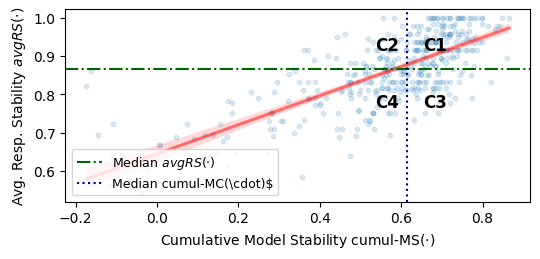

In [ ]:

plt.figure(figsize=(6,2.5))
sns.regplot(x='model_agreement', y='stability', data=cat_df, scatter_kws={'s':10, 'alpha':0.15}, line_kws={'color':'red', 'alpha':0.5}, robust=True)

plt.axhline(y=np.median(cat_df['stability']), color='darkgreen', linestyle='-.', label="Median $avgRS(\cdot)$")
plt.axvline(x=np.median(cat_df['model_agreement']), color='darkblue', linestyle='dotted', label="Median cumul-MC(\cdot)$")
plt.legend(fontsize=9, loc="lower left")

plt.xlabel("Cumulative Model Stability cumul-MS$(\cdot)$")
plt.ylabel("Avg. Resp. Stability $avgRS(\cdot)$", fontsize=10)

plt.annotate("C1", xy=(mc_median+0.04, stab_median+0.05), fontsize=12, fontweight="bold")
plt.annotate("C2", xy=(mc_median-0.08, stab_median+0.05), fontsize=12, fontweight="bold")

plt.annotate("C3", xy=(mc_median+0.04, stab_median-0.1), fontsize=12, fontweight="bold")
plt.annotate("C4", xy=(mc_median-0.08, stab_median-0.1), fontsize=12, fontweight="bold")

# plt.savefig("./aaai_images/participant_categories.png", bbox_inches='tight')


In [36]:
ent_df = []

for user in tqdm(sesssion_summary_df.user.unique()):
    user_df = sesssion_summary_df[sesssion_summary_df.user == user]
    sessions = sorted(user_df['session_number'].unique())
    cat = cat_df[cat_df.user==user].category_numeric.values[0]

    dist = 0
    for i, sess in enumerate(sessions):    
        if sess > 5:
            continue
        user_df_coefs = user_df[user_df['session_number'] == sess][diff_cols]
        entropy = np.abs(scipy.stats.entropy(np.abs(user_df_coefs.values[0])))
        reaction_time = user_df[user_df['session_number'] == sess]["mean_reaction_time"].values[0]
        if i != 0:
            dist += np.linalg.norm(user_df_coefs.values[0] - user_df[user_df['session_number'] == sessions[i-1]][diff_cols].values[0])**2

        ent_df.append([user, sess, entropy, reaction_time, dist, cat] + list(user_df_coefs.values[0]))

ent_df = pd.DataFrame(ent_df, columns=["user", "session", "entropy", "mean_reaction_time", "cumulative_model_shift", "category"] + feats)

  0%|          | 0/404 [00:00<?, ?it/s]

In [61]:
j=3
for f in feats:
    # print (f, ent_df[f].describe(), ent_df[ent_df.category == cgs[0]][f].describe())    
    print (f)
    print (np.mean(ent_df[f]), np.std(ent_df[f]))
    print (np.mean(ent_df[ent_df.category == cgs[j]][f]), np.std(ent_df[ent_df.category == cgs[j]][f]))

dep
0.06200343372875985 0.0608560684759733
0.05363673764621996 0.04560549479966409
alco
0.03975386739218398 0.03763330665607469
0.048693720796351564 0.043721665385200434
crim
0.05438052537023828 0.061081076233941836
0.049709523703367 0.04573477735007947
life
0.12223139816406554 0.08224570688978043
0.1109350554378422 0.07420696314657352
years_waiting
0.0760309785584106 0.07657282251690146
0.06464368458459864 0.05323871211330263
work_hours
0.03857700526429793 0.03299650831614988
0.047225222787906265 0.03883774165304658
obesity
0.04022213313684259 0.032893961978366866
0.04714975090615525 0.035986243077757434
reject_chance
0.08495285120611881 0.07335625163539057
0.08323060256598394 0.0647769883635979


In [29]:
from scipy.stats import linregress

cgs = ['C1 (RS-MS)', 'C2 (RS-MU)', 'C3 (RU-MS)', 'C4 (RU-MU)']
slopes = {}
for cg in cgs:
    sub_df = ent_df[ent_df.category == cg]
    slope, intercept, r_value, p_value, std_err = linregress(sub_df['session'], sub_df['entropy'])
    print (f"{cg}: slope = {slope:.4f}, p-value = {p_value:.4e}, r = {r_value:.4f}")
    

C1 (RS-MS): slope = -0.0374, p-value = 8.2136e-08, r = -0.2150
C2 (RS-MU): slope = -0.0406, p-value = 2.5222e-04, r = -0.2542
C3 (RU-MS): slope = -0.0171, p-value = 7.6502e-02, r = -0.1165
C4 (RU-MU): slope = -0.0106, p-value = 4.4373e-02, r = -0.0825


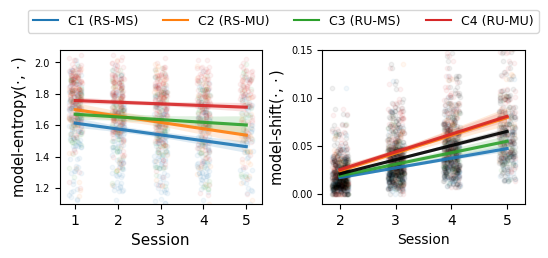

In [31]:
plt.figure(figsize=(6, 2))
# users_five_sessions = [user for user in ent_df.user.unique() if len(ent_df[ent_df.user == user].session.unique()) == 5]

plt.subplot(121)
ent_df.sort_values(by="category", ascending=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red
cgs = ['C1 (RS-MS)', 'C2 (RS-MU)', 'C3 (RU-MS)', 'C4 (RU-MU)']
for cg in cgs:
    sub_df = ent_df[ent_df.category==cg]
    # plt.scatter(sub_df['session'], sub_df["entropy"], s=10, alpha=0.1)
    sns.regplot(x='session', y='entropy', data=sub_df, scatter=True, color=colors[cgs.index(cg)], line_kws={'alpha':0.9, }, scatter_kws={'alpha':0.05, 's':10}, x_jitter=.15)
    plt.plot([], [], label=cg, color=colors[cgs.index(cg)])

plt.ylabel("model-entropy$(\cdot, \cdot)$", fontsize=10.5)
plt.xlabel("Session", fontsize=11)
plt.xticks(range(1,6))
plt.ylim(1.1, 2.08)
plt.yticks(fontsize=7)
plt.legend(ncol=4, bbox_to_anchor=(2.4, 1.3), fontsize=9)

plt.subplot(122)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red
cgs = ['C1 (RS-MS)', 'C2 (RS-MU)', 'C3 (RU-MS)', 'C4 (RU-MU)']
for cg in cgs:
    sub_df = ent_df[ent_df.category==cg]
    sub_df = sub_df[sub_df['session'] > 1]
    sns.regplot(x='session', y='cumulative_model_shift', data=sub_df, scatter=True, color=colors[cgs.index(cg)], line_kws={'alpha':0.9, }, scatter_kws={'alpha':0.05, 's':10}, x_jitter=.15)
    plt.plot([], [], label=cg, color=colors[cgs.index(cg)])

sns.regplot(x='session', y='cumulative_model_shift', data=ent_df[ent_df['session'] > 1], scatter=True, color="black", line_kws={'alpha':0.9, }, scatter_kws={'alpha':0.05, 's':10}, x_jitter=.15)


plt.ylabel("model-shift$(\cdot, \cdot)$", fontsize=10.5)
plt.xlabel("Session", fontsize=10)
plt.xticks(range(2,6))
plt.yticks(fontsize=7)
plt.ylim(-.01, .15)
 
plt.subplots_adjust(wspace=0.3)

# plt.savefig("./aaai_images/entropy_and_model_shift_by_session.png", bbox_inches='tight')


In [35]:
user_df

,user,session_number,start_time,end_time,mean_reaction_time,dep_diff,alco_diff,crim_diff,life_diff,years_waiting_diff,work_hours_diff,obesity_diff,reject_chance_diff,acc,auc
1663,11044189,1.0,2025-01-04 07:29:27,2025-01-04 07:41:07,0.099196,0.014372,0.067036,0.078622,0.238003,0.020048,0.046900,0.045646,0.041295,0.545455,0.733333
1664,11044189,2.0,2025-01-07 04:40:30,2025-01-07 04:42:49,0.034611,0.078562,0.065119,0.045142,0.179227,0.007431,0.017000,0.044707,0.068024,1.000000,1.000000
1665,11044189,3.0,2025-01-10 04:58:21,2025-01-10 05:06:01,0.055522,0.030040,0.014849,0.077984,0.236079,0.081508,0.004777,0.027586,0.007156,0.909091,1.000000
1666,11044189,4.0,2025-01-12 06:01:27,2025-01-12 06:07:54,0.047218,0.005984,0.010565,0.051364,0.275272,0.024218,0.041491,0.002913,0.052058,0.909091,0.964286


In [792]:
slopes = {}
for cg in cgs:
    sub_df = ent_df[ent_df.category == cg]
    slope, intercept, r_value, p_value, std_err = linregress(sub_df['session'], sub_df['cumulative_model_shift'])
    print (f"{cg}: slope = {slope:.4f}, p-value = {p_value:.4e}, r = {r_value:.4f}")


C1 (RS-MS): slope = 0.0117, p-value = 7.9294e-95, r = 0.7096
C2 (RS-MU): slope = 0.0212, p-value = 3.4703e-42, r = 0.7789
C3 (RU-MS): slope = 0.0143, p-value = 2.5052e-51, r = 0.7817
C4 (RU-MU): slope = 0.0204, p-value = 8.4466e-104, r = 0.7435


Text(0, 0.5, 'Mean reaction\n time (normalized)')

<Figure size 500x250 with 0 Axes>

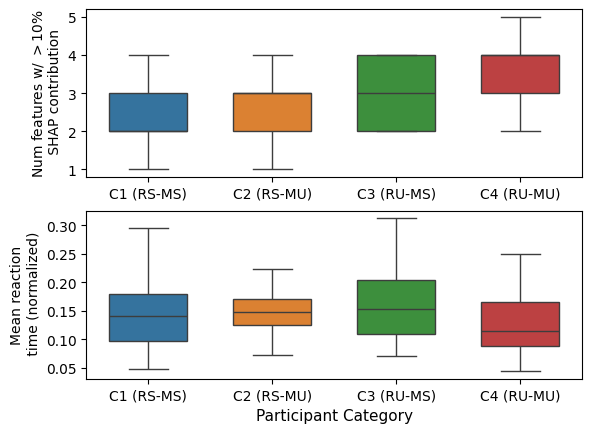

In [ ]:
def nf_used_shap(row):
    user = row['user']
    shap_vals = shap_dict[user]
    coefs = list(shap_vals.values())
    coefs = np.abs(coefs)/np.linalg.norm(coefs, ord=1)
    return np.sum(coefs > 0.1)

cat_df["nf_used_shap"] = cat_df.apply(lambda row: nf_used_shap(row), axis=1)

plt.figure(figsize=(5, 2.5))
fig, axs = plt.subplots(2, 1)
sns.boxplot(x='category_numeric', y="nf_used_shap", data=cat_df, showfliers=False, width=.7, gap=0.1, palette=colors, saturation=0.7, ax=axs[0])
axs[0].set_xlabel("", fontsize=11)
axs[0].set_ylabel("Num features w/ $>$10%\n SHAP contribution", fontsize=10)

sns.boxplot(x='category_numeric', y="mean_reaction_time", data=cat_df, showfliers=False, width=.7, gap=0.1, palette=colors, saturation=0.7, ax=axs[1])
axs[1].set_xlabel("Participant Category", fontsize=11)
axs[1].set_ylabel("Mean reaction\n time (normalized)", fontsize=10)
# plt.savefig("./aaai_images/feature_usage_reaction_time.png", bbox_inches='tight')

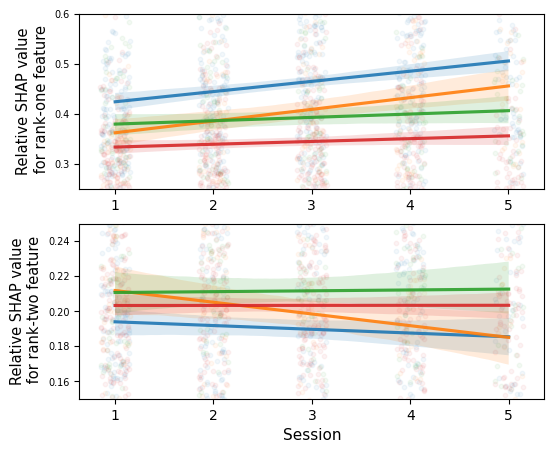

In [1093]:
def rank_x_weight(row, x):
    user = row['user']
    coefs = np.abs(row[diff_cols].values)
    coefs = coefs / np.linalg.norm(coefs, ord=1)  # Normalize to sum to 1
    coefs = sorted(coefs, reverse=True)
    return coefs[x]


sesssion_summary_df["rank_one_weight"] = sesssion_summary_df.apply(lambda row: rank_x_weight(row, 0), axis=1)
sesssion_summary_df["rank_two_weight"] = sesssion_summary_df.apply(lambda row: rank_x_weight(row, 1), axis=1)

sesssion_summary_df["category"] = sesssion_summary_df.apply(lambda row: cat_df[cat_df.user == row['user']].category_numeric.values[0], axis=1)

plt.figure(figsize=(6, 5))

plt.subplot(211)
ent_df.sort_values(by="category", ascending=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red
cgs = ['C1 (RS-MS)', 'C2 (RS-MU)', 'C3 (RU-MS)', 'C4 (RU-MU)']
for cg in cgs:
    sub_df = sesssion_summary_df[sesssion_summary_df.category==cg]
    sub_df = sub_df[sub_df['session_number'] <= 5]
    sns.regplot(x='session_number', y='rank_one_weight', data=sub_df, scatter=True, color=colors[cgs.index(cg)], line_kws={'alpha':0.9, }, scatter_kws={'alpha':0.05, 's':10}, x_jitter=.15)
    plt.plot([], [], label=cg, color=colors[cgs.index(cg)])

plt.ylabel("Relative SHAP value\n for rank-one feature", fontsize=10.5)
plt.xlabel("", fontsize=11)
plt.xticks(range(1,6))
plt.ylim(.25, .6)
plt.yticks(fontsize=7)


plt.subplot(212)
ent_df.sort_values(by="category", ascending=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red
cgs = ['C1 (RS-MS)', 'C2 (RS-MU)', 'C3 (RU-MS)', 'C4 (RU-MU)']
for cg in cgs:
    sub_df = sesssion_summary_df[sesssion_summary_df.category==cg]
    sub_df = sub_df[sub_df['session_number'] <= 5]
    sns.regplot(x='session_number', y='rank_two_weight', data=sub_df, scatter=True, color=colors[cgs.index(cg)], line_kws={'alpha':0.9, }, scatter_kws={'alpha':0.05, 's':10}, x_jitter=.15)
    plt.plot([], [], label=cg, color=colors[cgs.index(cg)])

plt.ylabel("Relative SHAP value\n for rank-two feature", fontsize=10.5)
plt.xlabel("Session", fontsize=11)
plt.xticks(range(1,6))
plt.ylim(.15, .25)
plt.yticks(fontsize=7)

plt.savefig("./aaai_images/feature_usage_over_sessions.png", bbox_inches='tight')

In [1094]:
# cat_df

### AI alignment

In [723]:
# cat_df["BT_MLP_accuracy"] = None
# for user in tqdm(cat_df.user.unique()):
#     df_user = df[df.tid == user]
#     # for session in df_user.session_number.unique():
#         # df_sess = df_user[df_user.session_number == session]
#     accs, _ = get_BT_model_performance(df_user, model_name="mlp", reps=5)

#     cat_df.loc[cat_df.user == user, "BT_MLP_accuracy"] = np.mean(accs)


  0%|          | 0/404 [00:00<?, ?it/s]

In [1095]:
cat_df["CLF_MLP_accuracy"] = None
for user in tqdm(cat_df.user.unique()):
    df_user = df[df.tid == user]
    accs, _ = get_clf_model_performance(df_user, model_name="lr")

    cat_df.loc[cat_df.user == user, "CLF_MLP_accuracy"] = np.mean(accs)


  0%|          | 0/404 [00:00<?, ?it/s]

In [1097]:

cat_df["BT_accuracy"] = None
for user in tqdm(cat_df.user.unique()):
    df_user = df[df.tid == user]
    accs, _ = get_BT_dpo_model_performance(df_user)

    cat_df.loc[cat_df.user == user, "BT_accuracy"] = np.mean(accs)


  0%|          | 0/404 [00:00<?, ?it/s]

In [1098]:
gpt_accuracy = pd.read_csv('./data/ext_data/GPT2_accuracy_aggregate.csv')

cat_df["LLM_FT_accuracy"] = None
nc = 0
for user in tqdm(cat_df.user.unique()):
    df_user = df[df.tid == user]
    acc = gpt_accuracy[gpt_accuracy.tid == user]['accuracy'].values
    if len(acc) == 0:
        continue
    cat_df.loc[cat_df.user == user, "LLM_FT_accuracy"] = acc[0]


  0%|          | 0/404 [00:00<?, ?it/s]

Text(0, 0.5, 'Error rate')

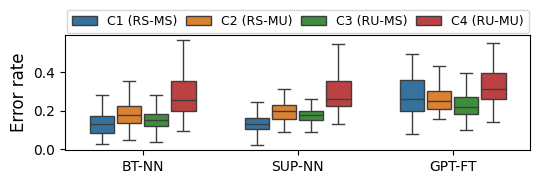

In [ ]:
cat_df = cat_df.sort_values(by="category_numeric")
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red

plt.figure(figsize=(6,1.5))
bx_df = []
for i, row in cat_df.iterrows():
    if row['LLM_FT_accuracy'] is None:
        continue
    bx_df.append([row['category_numeric'], 1-row['BT_accuracy'], "BT-NN"])
    bx_df.append([row['category_numeric'], 1-row['CLF_MLP_accuracy'], "SUP-NN"])
    bx_df.append([row['category_numeric'], 1-row['LLM_FT_accuracy'], "GPT-FT"])
bx_df = pd.DataFrame(bx_df, columns=["Category", "error_rate", "model"])

bx_df = bx_df[~pd.isna(bx_df['error_rate'])]
sns.boxplot(x='model', y="error_rate", hue="Category", data=bx_df, showfliers=False, width=.7, gap=0.1, palette=colors, saturation=0.7,)

plt.legend(ncol=4, fontsize=9, bbox_to_anchor=(0.5, 1.27), loc='upper center', columnspacing=0.7)
plt.xlabel("", fontsize=11)
plt.ylabel("Error rate", fontsize=12)
# plt.savefig("./aaai_images/aggregated_error_rate.png", bbox_inches='tight')


In [ ]:
import statsmodels.stats.api as sms
g1 = "C1 (RS-MS)"
# g1 = "C4 (RU-MU)"
# g1 = "C2 (RS-MU)"
g2 = "C3 (RU-MS)"

model_name = "GPT-FT"
error_c1 = np.array(bx_df[(bx_df.model==model_name) & (bx_df.Category == g1)]['error_rate'].values)
error_c4 = np.array(bx_df[(bx_df.model==model_name) & (bx_df.Category.isin(["C2 (RS-MU)", 'C3 (RU-MS)']))]['error_rate'].values)

print (np.mean(error_c1)-np.mean(error_c4))
cm = sms.CompareMeans(sms.DescrStatsW(error_c1), sms.DescrStatsW(error_c4))

print (cm.tconfint_diff(usevar='unequal'))

scipy.stats.ttest_ind(bx_df[(bx_df.model==model_name) & (bx_df.Category == g1)]['error_rate'],
              #  bx_df[(bx_df.model==model_name) & (bx_df.Category == 'C2 (RS-MU)')]['error_rate'],
              #  bx_df[(bx_df.model==model_name) & (bx_df.Category == 'C3 (RU-MS)')]['error_rate'],
               bx_df[(bx_df.model==model_name) & (bx_df.Category.isin(["C2 (RS-MU)", 'C3 (RU-MS)']))]['error_rate'])


0.0781191154274771
(0.05809587731285113, 0.0981423535421029)


TtestResult(statistic=7.168975525107943, pvalue=8.215103215677185e-12, df=254.0)

In [1105]:
gpt_predictions = pd.read_csv('data/GPT2_aggregate_predictions_v2.csv')
gpt_predictions["query_num_ts"] = gpt_predictions.apply(lambda row: (row["session_number"]-1)*60 + row["query_num"], axis=1)


In [1106]:
results = []

for user in tqdm(cat_df.user.unique()):  
    df_user = df[df.tid == user]
    sessions = df_user.session_number.unique()    
    if len(sessions) != 5:
        continue
    
    results = ai_performance_over_time(df, user, results, model_name="bt-dpo", gpt_predictions=gpt_predictions,)


  0%|          | 0/404 [00:00<?, ?it/s]

Skipping user 7164735, split_session 1 due to insufficient data.
Skipping user 452845, split_session 4 due to insufficient data.
Skipping user 9313260, split_session 2 due to insufficient data.
Skipping user 4782868, split_session 4 due to insufficient data.
Skipping user 3392798, split_session 3 due to insufficient data.
Skipping user 10750530, split_session 2 due to insufficient data.
Skipping user 9585552, split_session 4 due to insufficient data.
Skipping user 3517997, split_session 1 due to insufficient data.
Skipping user 9752535, split_session 2 due to insufficient data.
Skipping user 3566798, split_session 4 due to insufficient data.
Skipping user 1187370, split_session 1 due to insufficient data.
Skipping user 1187370, split_session 3 due to insufficient data.
Skipping user 1187370, split_session 4 due to insufficient data.


In [1107]:
results_df = pd.DataFrame(results, columns=['user', 'train_session', 'query_number', 'time_since_training', 'reaction_time', 'model_pref', 'human_pref', 'disagreement'])
results_df['time_since_training'] = (results_df['time_since_training'].apply(lambda x: x.total_seconds()/3600))  # Convert to hours
# results_df

In [1108]:
np.mean(results_df['disagreement'])

0.22134376613144238

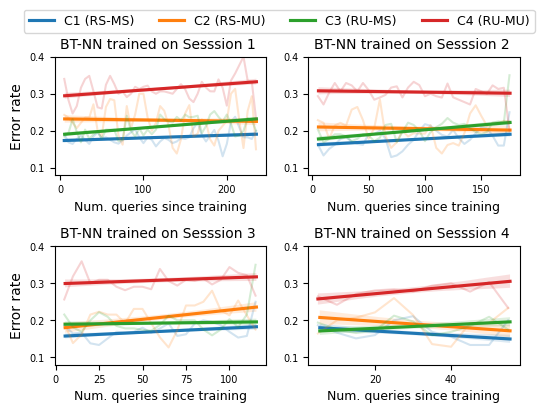

In [1109]:

def plot_by_session_model(res_df, session):
    bin_sizes=10
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red
    disag_df = [] 
    for i, cg in enumerate(['C1 (RS-MS)', 'C2 (RS-MU)', 'C3 (RU-MS)', 'C4 (RU-MU)']):
        cg_users = list(cat_df[cat_df.category_numeric==cg].user.unique())

        sub_df = res_df
        dpo_drates, ys = [], {}
        for user in cg_users:
            sub_df_user = sub_df[sub_df.user == user]
            sub_df_user.sort_values(by='query_number')

            cat_df_user = cat_df[cat_df.user == user]
            stability = cat_df_user["stability"].values[0]
            shift = cat_df_user["distance"].values[0]

            # total_bins = int(len(sub_df_user) / bin_sizes)
            # for b in range(total_bins):
            #     bin_start = b * bin_sizes
            #     bin_end = (b + 1) * bin_sizes

            for bin_start in range(0, len(sub_df_user)-bin_sizes, 1):
                bin_end = bin_start + bin_sizes

                sub_df_bin = sub_df_user.iloc[bin_start:bin_end]
                bin_center = (sub_df_bin['query_number'].min() + sub_df_bin['query_number'].max()) / 2
                if sub_df_bin['query_number'].max() > 300:
                    continue
                bin_center = bin_center - min(res_df.query_number) + 1
                time_center = (sub_df_bin['time_since_training'].min() + sub_df_bin['time_since_training'].max()) / 2
                disag = np.nanmean(sub_df_bin['disagreement'])
                # disag = np.mean(sub_df_bin.apply(lambda row: row['human_pref']*np.log(row['model_pref']) + (1-row['model_pref'])*np.log(1-row['model_pref']) , axis=1))

                dpo_drates.append([user, session, cg, bin_center, time_center, disag, stability, shift])

                if int(bin_center) not in ys.keys():
                    ys[int(bin_center)] = []
                ys[int(bin_center)].append(disag)

        disag_df += list(dpo_drates)
        dpo_drates_df = pd.DataFrame(dpo_drates, columns=['user', 'session', 'category',  'query_number', 'time_since_training', 'disagreement', 'response_stability', 'model_shift'])
        sns.regplot(x='query_number', y='disagreement', data=dpo_drates_df, label=cg, scatter=False, scatter_kws={"alpha":0.01, 's':10}, color=colors[i])
        
        ms, xs, es = [], [], []
        for key in sorted(list(ys.keys())):
            if len(xs) > 0 and key < xs[-1] + 5:
                continue
            xs.append(key)
            ms.append(np.mean(ys[key]))
            es.append(np.std(ys[key]))

        ms = np.array(ms)
        es = np.array(es)
        plt.plot(xs, ms, color=colors[i], alpha=0.2)
    return disag_df

plt.figure(figsize=(6, 4))

disag_df = []
for i, session in enumerate(range(1,5)):
    plt.subplot(220+session)
    res_df = results_df[results_df.train_session == session]
    dpo_drates = plot_by_session_model(res_df, session)
    disag_df += dpo_drates

    plt.ylim(.08, .4)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    if i in [0, 2]:
        plt.ylabel("Error rate", fontsize=10)
    else:
        plt.ylabel("")
    plt.xlabel(f"Num. queries since training", fontsize=9)
    plt.title(f"BT-NN trained on Sesssion {session} ", fontsize=10)

    if i==0:
        plt.legend(ncol=4, bbox_to_anchor=(2.3,1.45), fontsize=9)

plt.subplots_adjust(wspace=0.2, hspace=0.6)
# plt.savefig("./aaai_images/error_rate_over_time.png", bbox_inches='tight')
# 

In [1110]:
disag_df = pd.DataFrame(disag_df, columns=['user', 'session', 'category',  'query_number', 'time_since_training', 'disagreement', 'response_stability', 'model_shift'])

session = 4
category = "C1 (RS-MS)"
# category = "C4 (RU-MU)"
# category = "C2 (RS-MU)"
# category = "C3 (RU-MS)"
sub_df = disag_df[(disag_df.session == session) & (disag_df.category == category)]
model = smf.ols(formula='disagreement ~ query_number', data=sub_df).fit()
print (model.pvalues)
print (model.tvalues)
# print (model.summary())


Intercept       6.657059e-153
query_number     1.689202e-03
dtype: float64
Intercept       28.510956
query_number    -3.143841
dtype: float64


In [1112]:
from IPython.core.display import HTML


models = []
for i in range(1,5):
    sub_df = disag_df[disag_df.session == i]
    sub_df['log_query_number'] = np.log(sub_df['query_number'])
    sub_df['log_time_since_training'] = np.log(sub_df['time_since_training']*3600 + 1e-8)  
    
    model = smf.ols('disagreement ~ 0+ log_query_number*category', data=sub_df).fit()
    models.append(model)

stargazer = Stargazer(models)
HTML(stargazer.render_html())
# print (stargazer.render_latex())

#### analysis of self-reported and qualitative data

In [267]:
qual_scores_df = pd.read_csv('./data/qual_data/self_reported_feature_importance.csv')
qual_ranks_df = pd.read_csv('./data/qual_data/self_reported_feature_ranks.csv')
qual_text_df = pd.read_csv('./data/qual_data//qualitative_feature_importance.csv')
# qual_text_df

In [940]:
def dist_from_qual_scores(row):
    user = row['user']
    qual_row = qual_scores_df[qual_scores_df.tid == user]
    if len(qual_row) == 0:
        return np.nan
    qual_scores = qual_row.iloc[0][feats].values
    qual_scores = qual_scores / np.linalg.norm(qual_scores, ord=1)  # Normalize to sum to 1
    coefs = list(shap_dict[user].values())
    coefs = np.abs(coefs) / np.linalg.norm(coefs, ord=1)  # Normalize to sum to 1
    return np.linalg.norm(qual_scores - coefs)

def dist_from_qual_ranks(row):
    user = row['user']
    qual_row = qual_ranks_df[qual_ranks_df.tid == user]
    if len(qual_row) == 0:
        return np.nan
    qual_ranks = qual_row.iloc[0][feats].values
    coefs = list(shap_dict[user].values())
    qual_ranks = np.argsort(qual_ranks)
    coefs = np.argsort(coefs)
    return np.linalg.norm(qual_ranks - coefs)

def dist_from_qual_text(row):
    user = row['user']
    qual_row = qual_text_df[qual_text_df.tid == user]
    if len(qual_row) == 0:
        return np.nan
    qual_scores = qual_row.iloc[0][feats].values
    qual_scores = qual_scores / np.linalg.norm(qual_scores, ord=1)  # Normalize to sum to 1
    coefs = list(shap_dict[user].values())
    coefs = np.array(coefs) / np.linalg.norm(coefs, ord=1)  # Normalize to sum to 1
    return np.linalg.norm(qual_scores - coefs)

cat_df["dist_from_qual_scores"] = cat_df.apply(lambda row: dist_from_qual_scores(row), axis=1)
cat_df["dist_from_qual_ranks"] = cat_df.apply(lambda row: dist_from_qual_ranks(row), axis=1)
cat_df["dist_from_qual_text"] = cat_df.apply(lambda row: dist_from_qual_text(row), axis=1)

In [1042]:
ys = "dist_from_qual_text"

cat_df = cat_df[cat_df[ys].notnull()]
f_oneway(cat_df[cat_df.category_numeric == 'C1 (RS-MS)'][ys],
        cat_df[cat_df.category_numeric == 'C2 (RS-MU)'][ys],
        cat_df[cat_df.category_numeric == 'C3 (RU-MS)'][ys],
        cat_df[cat_df.category_numeric == 'C4 (RU-MU)'][ys],
        )


F_onewayResult(statistic=2.0679994029967657, pvalue=0.10509145666229502)

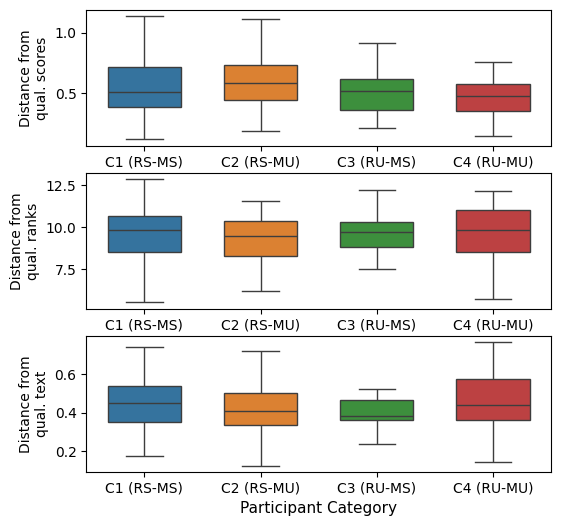

In [944]:
fig, axs = plt.subplots(3,1, figsize=(6,6))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red
sns.boxplot(x='category_numeric', y="dist_from_qual_scores", data=cat_df, showfliers=False, width=.7, gap=0.1, palette=colors, saturation=0.7, ax=axs[0])
axs[0].set_xlabel("", fontsize=11)
axs[0].set_ylabel("Distance from\nqual. scores", fontsize=10)

sns.boxplot(x='category_numeric', y="dist_from_qual_ranks", data=cat_df, showfliers=False, width=.7, gap=0.1, palette=colors, saturation=0.7, ax=axs[1])
axs[1].set_xlabel("", fontsize=11)
axs[1].set_ylabel("Distance from\nqual. ranks", fontsize=10)

sns.boxplot(x='category_numeric', y="dist_from_qual_text", data=cat_df, showfliers=False, width=.7, gap=0.1, palette=colors, saturation=0.7, ax=axs[2])
axs[2].set_xlabel("Participant Category", fontsize=11)
axs[2].set_ylabel("Distance from\nqual. text", fontsize=10)
plt.savefig("./aaai_images/qualitative_distances.png", bbox_inches='tight')

### demographic analysis

In [260]:
dem_df_new = pd.read_csv("./data/dem_data/day_1_data.csv")

all_ids = dem_df_new['ID']
all_tids = [str(id).split('-')[1] if len(str(id).split('-')) > 1 else str(id) for id in all_ids]
dem_df_new["tid"] = all_tids

dem_df_sub = dem_df_new[["ID", "tid", "age", "race quota", "Q7"]]
dem_df_sub["gender"] = dem_df_new["Q7"]
dem_df_sub["race"] = dem_df_sub["race quota"]
dem_df_sub = dem_df_sub[["tid", "age", "race", "gender"]]

# Remove rows where tid is 'ID' or cannot be converted to int
dem_df_sub = dem_df_sub[dem_df_sub["tid"] != "ID"]
dem_df_sub = dem_df_sub[dem_df_sub["tid"] != '{"ImportId":"ID"}']
dem_df_sub = dem_df_sub[dem_df_sub["tid"] != "nan"]

dem_df_sub = dem_df_sub[dem_df_sub["tid"].notna()]

# Force convert df_sub tid to int
dem_df_sub["tid"] = dem_df_sub["tid"].astype(int)

dem_df_sub["gender"].value_counts()/len(dem_df_sub)

gender
Female                                 0.606085
Male                                   0.384307
Other (Please specify in box below)    0.008807
Prefer not to answer                   0.000801
Name: count, dtype: float64

In [ ]:
demographics_df_expanded = pd.read_csv('./data/dem_data/expanded_demographic_data.csv')
demographics_df_expanded.columns

Index(['tid', 'Age', 'Race', 'Gender', 'Race_Group', 'Age_Group', 'Full_Group',
       'religion', 'how_religious', 'social_political_orientation',
       'economic_political_orientation', 'marital_status', 'education',
       'employment', 'household income'],
      dtype='object')

In [263]:
response_stabilities, agreements = [], []

for i, row in demographics_df_expanded.iterrows():
    user = row['tid']
    if user not in cat_df.user.values:
        response_stabilities.append(None)
        agreements.append(None)     
        continue   
    response_stability = stability_by_user_df[stability_by_user_df.user == user]['stability'].values[0]
    model_agreement = cat_df[cat_df.user == user]['model_agreement'].values[0]

    response_stabilities.append(response_stability)
    agreements.append(model_agreement)


In [264]:
demographics_df_expanded["response_stability"] = response_stabilities
demographics_df_expanded["model_agreement"] = agreements
demographics_df_sub = demographics_df_expanded[demographics_df_expanded.response_stability.notnull()]
len(demographics_df_sub), demographics_df_sub.columns

(239,
 Index(['tid', 'Age', 'Race', 'Gender', 'Race_Group', 'Age_Group', 'Full_Group',
        'religion', 'how_religious', 'social_political_orientation',
        'economic_political_orientation', 'marital_status', 'education',
        'employment', 'household income', 'response_stability',
        'model_agreement'],
       dtype='object'))

In [265]:
from IPython.core.display import HTML

#check whether significant differences exist across demographic groups using regression
import statsmodels.formula.api as smf
cols = ["Age", "Race_Group", "Gender", "how_religious", "employment", "social_political_orientation", "economic_political_orientation"]

model1 = smf.ols(formula='response_stability ~ ' + " + ".join(cols), data=demographics_df_sub).fit()
model2 = smf.ols(formula='model_agreement ~ ' + " + ".join(cols), data=demographics_df_sub).fit()

stargazer = Stargazer({model1, model2})
HTML(stargazer.render_html())
